# <center> Stroke Prediction - Final Notebook
## <center> Notebook Overview
Here be the overview of what this notebook entails.

## <center> Executive Summary
Here be the executive summary of the work done in this notebook.
    
## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split

import prepare
import model

# <center> 1. Wrangle
## Wrangle Overview
1. Acquired dataset from Kaggle
1. Dropped outliers in BMI and gender columns
1. Renamed columns, cast columns to appropriate data types, dropped unnecessary columns
1. Imputed nulls in BMI column using average BMI for age range and gender
1. Plotted univariate distributions to check work
1. Noticed class imbalance and need for SMOTE+Tomek resampling
1. Encoded categorical columns identified from univariate distributions
1. Converted ordinal values from 1s and 0s to True and False values from univariate distributions
1. Created bmi_range column for BMI grouping from univariate distributions
1. Created high_glucose feature based on Explore analysis
1. Created is_senior feature based on Explore analysis
1. Split data into Train, Validate, and Test splits

## Cleaning the Data
First up, we need to clean the dataset for exploration. The specific steps are described above. These steps were put to a function in prepare.py, which we call in the following cell.

In [2]:
# Use the prep_data function to prepare the data
df = prepare.prep_data(pd.read_csv('healthcare-dataset-stroke-data.csv'))

# Check results
print(f'Shape: {df.shape[0]} rows, {df.shape[1]} columns.')
df.head(3)

Shape: 5107 rows, 12 columns.


,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_range
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,65-70
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.6,never smoked,1,60-65
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,75-80


## Univariate Distribution Plots
Here, we will check to make sure our distributions look okay. 

------------------------------   gender   ------------------------------


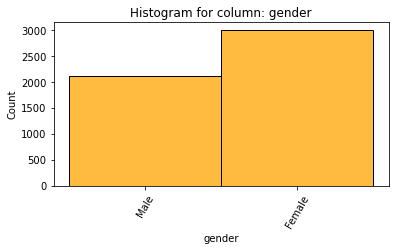

------------------------------   age   ------------------------------


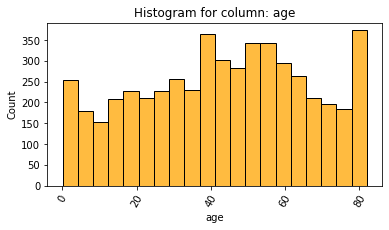

------------------------------   hypertension   ------------------------------


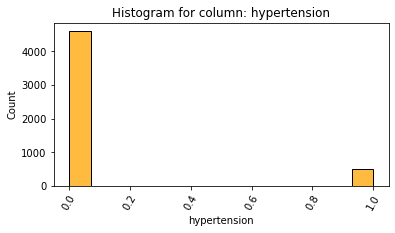

------------------------------   heart_disease   ------------------------------


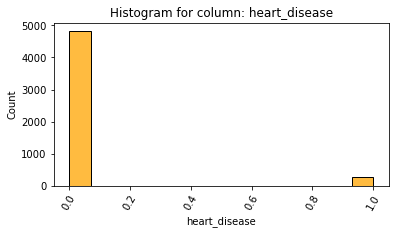

------------------------------   ever_married   ------------------------------


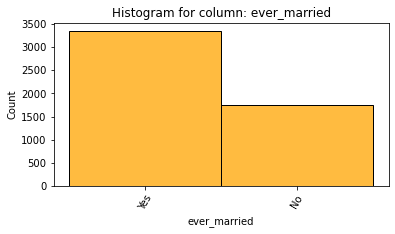

------------------------------   work_type   ------------------------------


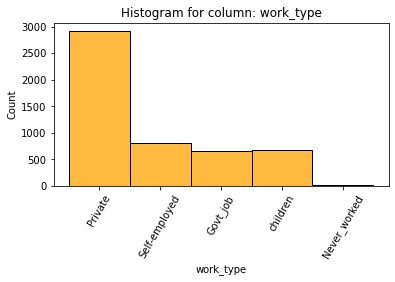

------------------------------   residence_type   ------------------------------


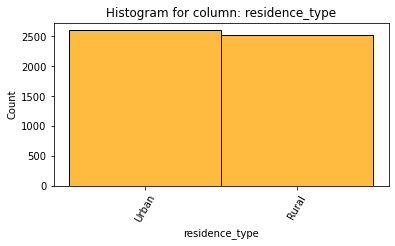

------------------------------   avg_glucose_level   ------------------------------


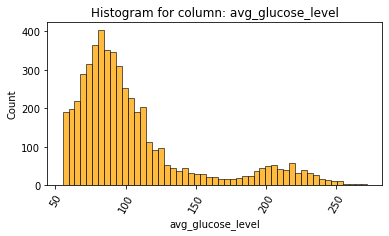

------------------------------   bmi   ------------------------------


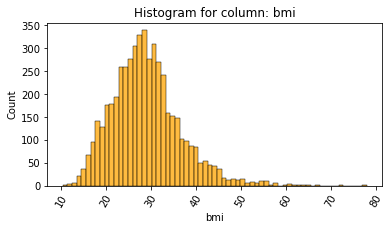

------------------------------   smoking_status   ------------------------------


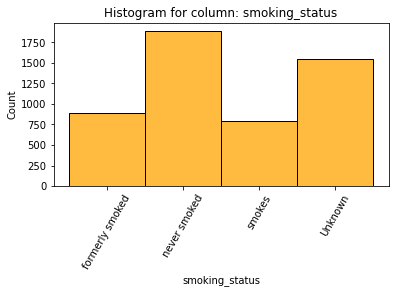

------------------------------   stroke   ------------------------------


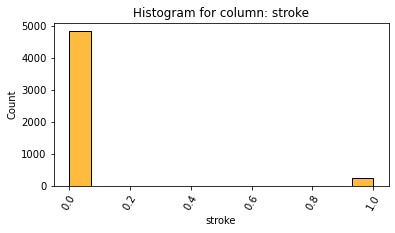

------------------------------   age_range   ------------------------------


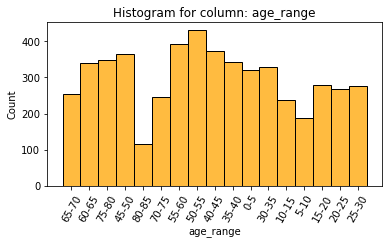

In [3]:
# Plot univariate distributions for each column
for col in df.columns:
    plt.figure(figsize=(6,3))
    print('-'*30, ' ', col, ' ', '-'*30) # use a line separator charts
    sns.histplot(df[col], color='#ffa500')
    plt.title('Histogram for column: ' + col)
    plt.xticks(rotation=60)
    plt.show()

## Need for SMOTE + Tomek Oversampling
Our target is imbalanced, as can be seen below. We will need to use SMOTE + Tomek Oversampling later on in the Modeling section to train our classification models with balanced classes.

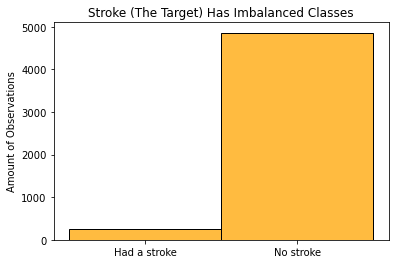

In [4]:
# Plot histogram showing class imbalance in 'stroke' column
sns.histplot(np.where(df.stroke == 1, 'Had a stroke', 'No stroke'), color='#ffa500')
plt.title('Stroke (The Target) Has Imbalanced Classes')
plt.ylabel('Amount of Observations')
plt.show()

## Feature Engineering
From these univariate distributions, we've decided to modify some features for exploration purposes. We've also incorporated some feature engineering based on analysis done in the Explore stage. This work is captured by the engineer_features function in prepare.py. 

Note: *We've combined the 'children' work type and the 'Never_worked' work type because there was overlap for those under 18 years old having the latter work type.* All other features are simply encoded or have additional columns with categorization.

In [5]:
# engineer features
engineered_df = prepare.engineer_features(df)

Original shape: 5107 rows, 12 columns.
New shape: 5107 rows, 21 columns.


In [6]:
# check results
engineered_df.head(3)

,stroke,age,age_range,is_senior,bmi,bmi_range,avg_glucose_level,high_glucose,has_hypertension,has_heart_disease,...,is_female,is_urban,smoking_status,current_smoker,prior_smoker,never_smoked,govt_job,self_employed,private_work,never_worked
0,1,67.0,65-70,True,36.6,30-39,228.69,True,False,True,...,False,True,formerly smoked,False,True,False,False,False,True,False
1,1,61.0,60-65,True,30.6,30-39,202.21,True,False,False,...,True,False,never smoked,False,False,True,False,True,False,False
2,1,80.0,75-80,True,32.5,30-39,105.92,False,False,True,...,False,False,never smoked,False,False,True,False,False,True,False


## Split data for Exploration
In order to explore on in-sample data, we will split our dataset into in-sample data and out-of-sample data. We will use the two out-of-sample splits for modeling purposes. Our splits are 60% in-sample and 20% for each out-of-sample split.

In [7]:
# Split data 60-20-20 into Train, Validate, and Test splits
train_validate, test = train_test_split(engineered_df, test_size=0.2, random_state=777)
train, validate = train_test_split(train_validate, test_size=0.25, random_state=777)

print(f'Train shape: {train.shape}, Validate shape: {validate.shape}, Test shape: {test.shape}')
print('Row count of original dataset:', df.shape[0])
print('Row count of combined data splits:', train.shape[0] + validate.shape[0] + test.shape[0])

Train shape: (3063, 21), Validate shape: (1022, 21), Test shape: (1022, 21)
Row count of original dataset: 5107
Row count of combined data splits: 5107


## Wrangle Summary
- Cleaned the dataset
- Checked distributions, noticed class imbalance
- Engineered features in preparation for exploration
- Split data

# <center>2. Explore
## Exploration Overview
1. Answered initial hypotheses
1. *Bivariate:* Split features on No Stroke and Had Stroke, visualized differences
1. Eliminated features that weren't significantly different between No Stroke and Had Stroke
1. Determined that 'age' might be causing some features to seem as if they have a dependent relationship with 'stroke'
1. *Multivariate:* Split features on 'age' and 'stroke' using 55 years old as the split point, visualized differences
1. Eliminated features that did not have a dependent relationship to stroke in either of the isolated under-55 and over-55 age groups
1. Incorporated remaining features into prepare script for modeling

## Initial Hypotheses
Before analyzing this data, our team created four initial hypotheses:
- Hypothesis 1: On average, an increase in BMI corresponds with an increase in average glucose level.
- Hypothesis 2: On average, a person who has had a stroke is older than someone who has not.
- Hypothesis 3: Smoking has an impact on stroke occurrence.
- Hypothesis 4: Men are more at risk for stroke than women.

The following work answers these hypotheses.

### Hypothesis 1: On average, an increase in BMI corresponds with an increase in average glucose level.
> - $H_0$ : An increase in BMI does not correspond with an increase in average glucose level.
> - $H_a$ : An increase in BMI corresponds with an increase in average glucose level.
> - Confidence interval is 95%

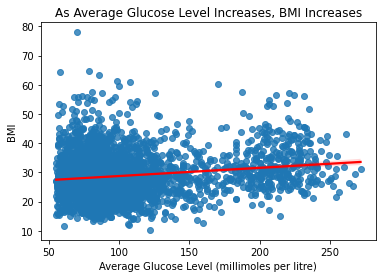

In [8]:
# visualize: use regression plot to check linear trend
sns.regplot(data=train, x="avg_glucose_level", y="bmi", line_kws={'color': 'red'})
plt.title('As Average Glucose Level Increases, BMI Increases')
plt.xlabel('Average Glucose Level (millimoles per litre)')
plt.ylabel('BMI')
plt.show()

In [9]:
# statistical test: set alpha for test
alpha = .05

# statistical test: conduct pearson r test 
corr, p = stats.pearsonr(train.avg_glucose_level, train.bmi)

# statistical test: output results
if p < alpha and corr > 0:
    print('We are 95% confident that an increase in BMI corresponds with an increase in average glucose level.')
else:
    print('We can not say with 95% confidence that an increase in BMI corresponds with an increase in average glucose level.')

We are 95% confident that an increase in BMI corresponds with an increase in average glucose level.


### Hypothesis 2: On average, a person who has had a stroke is older than someone who has not.
> - $H_0$ : A person who has had a stroke is not statistically-significantly older than someone who has not.
> - $H_a$ : A person who has had a stroke is statistically-significantly older than someone who has not.
> - Confidence interval is 95%

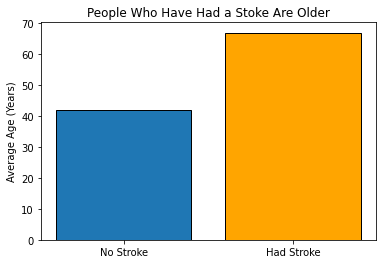

In [10]:
# prepare: split samples into two dataframes
had_stroke = train.stroke == 1

# visualize: build data for bar plot
x = ['No Stroke', 'Had Stroke']
y = [round(train[had_stroke == False].age.mean()),
     round(train[had_stroke].age.mean())]

# visualize: apply data to bar plot
plt.bar(x=x, height=y, color=['#1f77b4','#ffa500'], ec='black')
plt.title('People Who Have Had a Stoke Are Older')
plt.ylabel("Average Age (Years)")
plt.show()

In [11]:
# statistical test: set alpha
alpha = .05

# statistical test: conduct chi2 contingency test
stroke = train.stroke == 1
no_stroke = train.stroke == 0
t, p = stats.mannwhitneyu(train[stroke].age, train[no_stroke].age, alternative='greater')

# statistical test: output results
if p < alpha:
    print('We are 95% confident that people who have had a stroke are older on average than people who have not.')
else:
    print('We can not say with 95% confidence that people who have had a stroke are older on average than people who have not.')

We are 95% confident that people who have had a stroke are older on average than people who have not.


### Hypothesis 3: Smoking has an impact on stroke occurrence.
> - $H_0$ : Smoking does not have an impact on stroke occurrence.
> - $H_a$ : Smoking has an impact on stroke occurrence.
> - Confidence interval is 95%

In [12]:
# prepare: eliminate unknowns, split rest into ever-smoked and never-smoked
know_smoke_status = train[train.smoking_status != 'Unknown']
know_smoke_status['smokers'] = ((know_smoke_status['smoking_status'] == 'smokes') | 
                                (know_smoke_status['smoking_status'] == 'formerly smoked'))

# prepare: create crosstab of samples and stroke occurrence for chi2 test
smoker_crosstab = know_smoke_status.groupby('smokers').stroke.value_counts().unstack()

# prepare: add labels to crosstab
smoker_crosstab.rename(columns={0:'No Stroke', 1:'Had Stroke'}, 
                       index={0:'Not Smokers', 1:'Smokers'}, 
                       inplace=True)

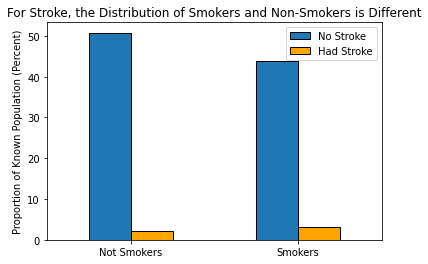

In [13]:
# visualize: convert dataframe counts to percentages
smoker_crosstab_total = smoker_crosstab.values.sum()
smoker_viz = (smoker_crosstab / smoker_crosstab_total) * 100

# visualize: plot the percentages
smoker_viz.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title('For Stroke, the Distribution of Smokers and Non-Smokers is Different')
plt.xlabel('')
plt.ylabel('Proportion of Known Population (Percent)')
plt.legend()
plt.show()

In [14]:
# statistical test: set alpha
alpha = .05

# statistical test: run chi2 test
_, p, _, _ = stats.chi2_contingency(smoker_crosstab)

# statistical test: output results
if p < alpha:
    print('We are 95% confident that smoking has an impact on stroke occurrence.')
else:
    print('We can not say with 95% confidence that smoking has an impact on stroke occurrence.')

We are 95% confident that smoking has an impact on stroke occurrence.


### Hypothesis 4: Men and women have different stroke occurrence rates.
> - $H_0$ : Men and women do not have different stroke occurrence rates.
> - $H_a$ : Men and women have different stroke occurrence rates.
> - Confidence interval is 95%

In [15]:
# prepare: create new column for crosstab
train['is_female'] = np.where(train['is_female'] == "True", "Female", "Male")

# prepare: create crosstab of samples and stroke occurrence for chi2 test
gender_crosstab = pd.crosstab(train['is_female'], train['stroke'])

# prepare: add labels
gender_crosstab.rename(columns={0:'No Stroke', 1:'Had Stroke'}, 
                       index={0:'Male', 1:'Female'},
                       inplace=True)

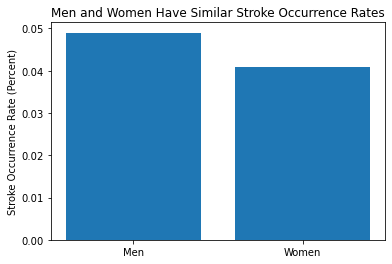

In [16]:
# visualize: create samples for men and women
men = train[train.is_female == "Male"]
women = train[train.is_female == "Female"]

# visualize: plot sample means for stroke
x = ['Men', 'Women']
y = [round(men.stroke.mean(), 3), round(women.stroke.mean(), 3)]

plt.bar(x=x, height=y)
plt.title('Men and Women Have Similar Stroke Occurrence Rates')
plt.ylabel("Stroke Occurrence Rate (Percent)")
plt.show()

In [17]:
# statistical test: set alpha
alpha = .05

# statistical test: run chi2 test
_, p, _, expected = stats.chi2_contingency(gender_crosstab)

# statistical test: output results
if p < alpha:
    print('We are 95% confident that men and women have different stroke occurrence rates.')
else:
    print("We can't say with 95% confidence that men and women have different stroke occurrence rates.")

We can't say with 95% confidence that men and women have different stroke occurrence rates.


### Initial Hypotheses - Combined Results
> #### We are 95% confident that an increase in BMI corresponds with an increase in average glucose level.
> #### We are 95% confident that people who have had a stroke are older on average than people who have not.
> #### We are 95% confident that smoking has an impact on stroke occurrence.
> #### We can't say with 95% confidence that men and women have different stroke occurrence rates.

## Initial Bivariate Analysis
Our first step after testing initial hypotheses is to explore how features are distributed for No Stroke and Had Stroke, our two target classes. Below, we run stats tests and generate visualizations for all features and both of the target classes. 

### Continuous Independent Variables and Stroke - Comparison of Means

In [18]:
# select continuous columns
cont_cols = ['age','bmi','avg_glucose_level']
# init empty statement dict to post with bivariate visualizations
statement_dict = {}
# loop through mannwhitneyu tests for whether stroke/not-stroke samples are different on col
for col in cont_cols:
    # set alpha
    alpha = .05
    # test
    t, p = stats.mannwhitneyu(train[train.stroke == 0][col], 
                              train[train.stroke == 1][col],
                              alternative='two-sided')
    # save statement
    if t != 0 and p < alpha / 2:
        statement = f"Mean value of '{col}' between had-stroke and no-stroke is significantly different."
    else:
        statement = f"Mean value of '{col}' between had-stroke and no-stroke is not significantly different."
    # add statement to dict
    statement_dict[col] = statement

### Categorical Intependent Variables and Stroke - Independence Testing

In [19]:
# select categorical columns
cat_cols = train.columns[7:].tolist()
# loop through chi-square contingency tests to see if stroke is dependent
for col in cat_cols:
    # set alpha
    alpha = .05
    # create crosstab
    stroke_col_crosstab = pd.crosstab(train[col], train['stroke'])
    # test
    _, p, _, _ = stats.chi2_contingency(stroke_col_crosstab)
    # save statement
    if p < alpha:
        statement = f"The 'stroke' and '{col}' columns are dependent."
    else:
        statement = f"The 'stroke' and '{col}' columns are not dependent."
    # add statement to dict
    statement_dict[col] = statement

### Visualizations of Independent Variables and Stroke

-------------------- age --------------------


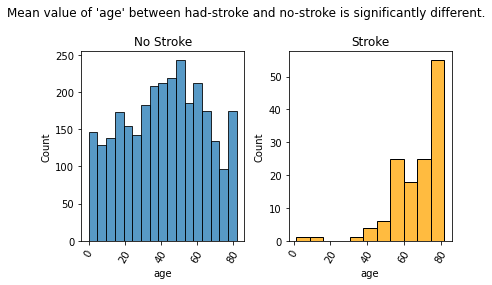

-------------------- bmi --------------------


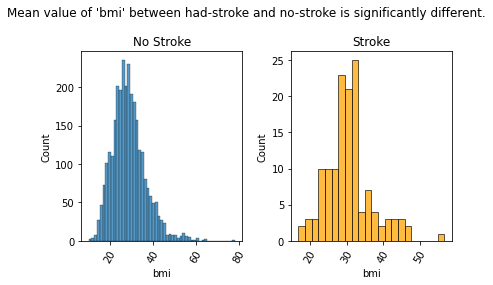

-------------------- avg_glucose_level --------------------


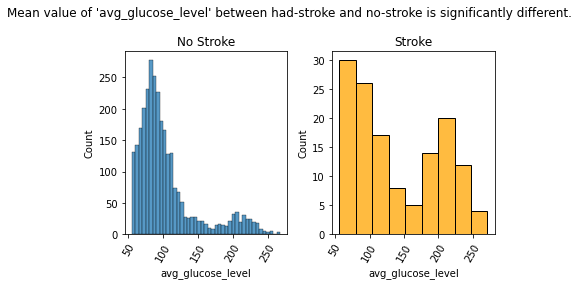

-------------------- high_glucose --------------------


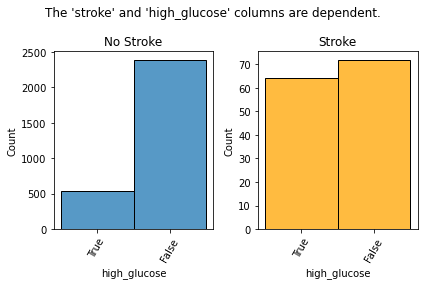

-------------------- has_hypertension --------------------


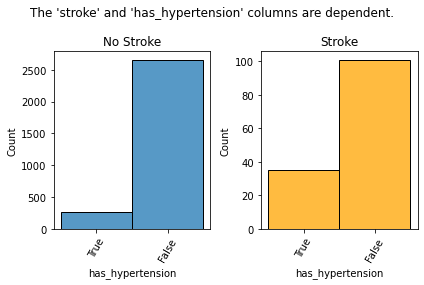

-------------------- has_heart_disease --------------------


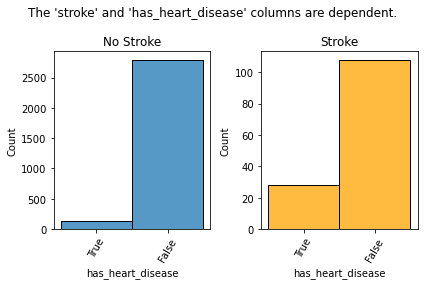

-------------------- ever_married --------------------


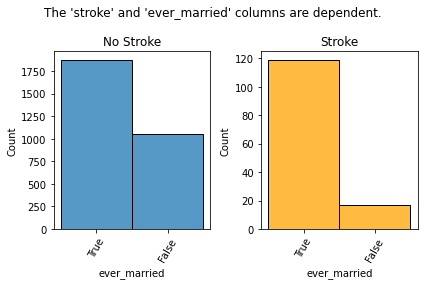

-------------------- is_female --------------------


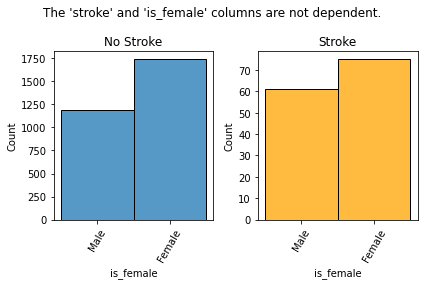

-------------------- is_urban --------------------


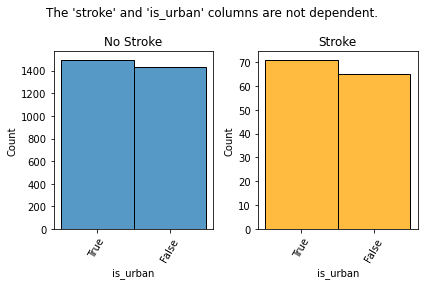

-------------------- current_smoker --------------------


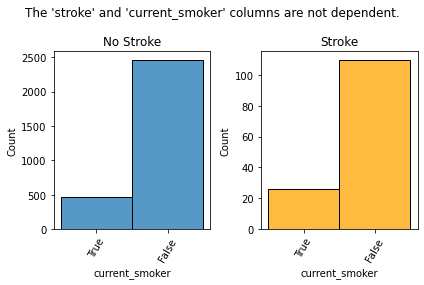

-------------------- prior_smoker --------------------


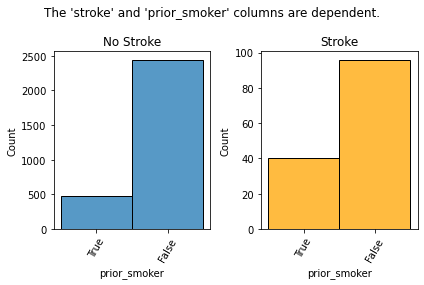

-------------------- never_smoked --------------------


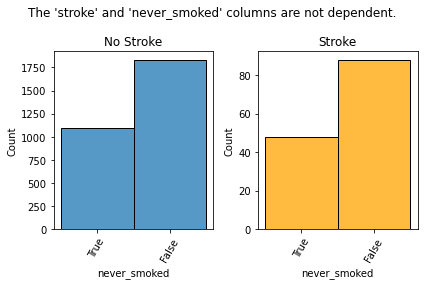

-------------------- govt_job --------------------


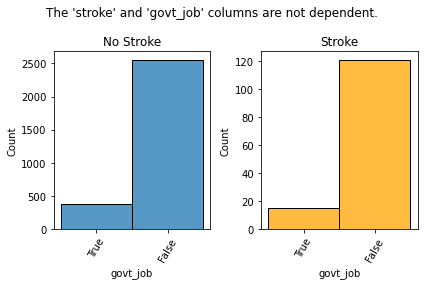

-------------------- self_employed --------------------


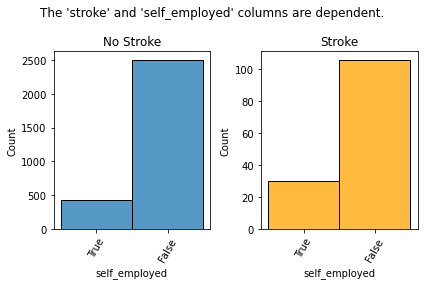

-------------------- private_work --------------------


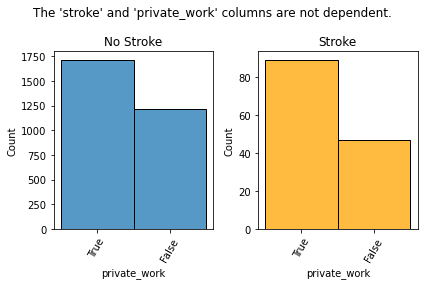

-------------------- never_worked --------------------


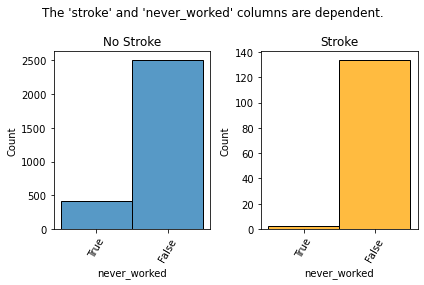

In [20]:
# initial chart look (looking for differences between left chart and right chart for each)
col_list_to_drop = ['stroke','is_senior','age_range','bmi_range','smoking_status']
for col in train.drop(columns=col_list_to_drop).columns:
    print('-'*20, col, '-'*20)
    # visualization
    plt.subplot(121) # Observations without stroke (left charts)
    plt.title('No Stroke')
    sns.histplot(train[train.stroke == 0][col].sort_values(ascending=False))
    plt.xticks(rotation=60)
    plt.subplot(122) # Observations with stroke (right charts)
    plt.title('Stroke')
    sns.histplot(train[train.stroke == 1][col].sort_values(ascending=False), color='#ffa500')
    plt.xticks(rotation=60)
    plt.suptitle(statement_dict[col]) # use statement from stats tests as viz title
    plt.tight_layout()
    plt.show()

## Results of Bivariate Visualizations
Features **with significant differences** between No Stroke and Had Stroke (**keep**):
- age
- bmi
- avg_glucose_level
- high_glucose
- has_hypertension
- has_heart_disease
- ever_married
- prior_smoker
- self_employed
- never_worked

Features **without significant differences** between No Stroke and Had Stroke (**remove**):
- is_female
- is_urban
- current_smoker
- never_smoked
- govt_job
- private_work

In [21]:
# drop the 'remove' features from our exploration split
train = train.drop(columns=['is_female','is_urban',
                            'current_smoker','never_smoked',
                            'govt_job','private_work'])

# print current columns
print(train.columns.tolist())

['stroke', 'age', 'age_range', 'is_senior', 'bmi', 'bmi_range', 'avg_glucose_level', 'high_glucose', 'has_hypertension', 'has_heart_disease', 'ever_married', 'smoking_status', 'prior_smoker', 'self_employed', 'never_worked']


## Age May Drive Other Features
The 'age' column has a significant difference in distribution between no-stroke and stroke. The team suspects that **age may be driving stroke occurrence and also driving other features.** It's possible that some features may not drive stroke occurrence- only appear to do so because they are being driven by age, which (likely) is driving stroke.

The following visualization shows the difference that prompted this investigation.

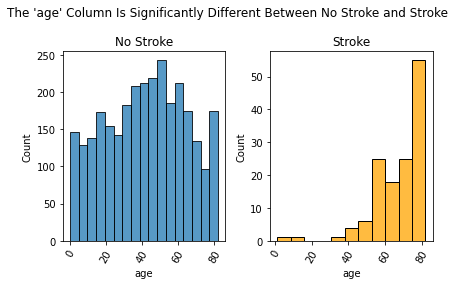

In [22]:
# show the difference in distribution for age between no stroke and stroke
plt.subplot(121) # Observations without stroke (left charts)
plt.title('No Stroke')
sns.histplot(train[train.stroke == 0]['age'].sort_values(ascending=False))
plt.xticks(rotation=60)
plt.subplot(122) # Observations with stroke (right charts)
plt.title('Stroke')
sns.histplot(train[train.stroke == 1]['age'].sort_values(ascending=False), color='#ffa500')
plt.xticks(rotation=60)
plt.suptitle("The 'age' Column Is Significantly Different Between No Stroke and Stroke")
plt.tight_layout()
plt.show()

## Determining if Age Matters for a Feature
### Visual Determination - Continuous Independent Variables
To check visually if continuous features differ on stroke regardless of age, we will use the feature 'is_senior' to split the data into two age-group samples, Over-55 and Under-55. Then, we will calculate the mean value for the continuous feature for all four combinations of stroke and age-group classes. We will inspect the height differences in a bar chart of the four values. The implementation is in the following charts.

Steps:
1. Look for how much bigger/smaller the orange bar is to the blue for Under 55 Years Old.
2. Look at the size difference for Over 55 Years Old.
3. Compare the size difference of Under 55's blue/orange ratio to Over 55's blue/orange ratio.
4. Takeaways come from the comparison in step 3.

### 1. BMI

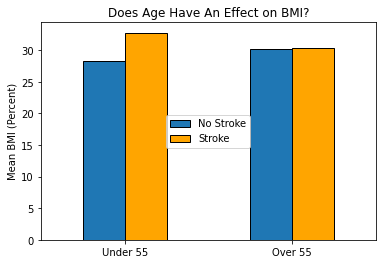

In [23]:
# calculate values for chart
stroke_bmi = train.groupby(['is_senior','stroke']).bmi.mean().unstack()
stroke_bmi.rename(columns={0:'No Stroke', 1:'Stroke'},
                  index = {"False":'Under 55', "True":'Over 55'},
                  inplace=True)

# plot
stroke_bmi.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title('Does Age Have An Effect on BMI?')
plt.xlabel('')
plt.ylabel('Mean BMI (Percent)')
plt.legend(loc='center')
plt.show()

- BMI is slightly higher for those under 55 years old who have had a stroke, but even for those over 55.
- BMI is similar between age groups.

### 2. Average Glucose Level

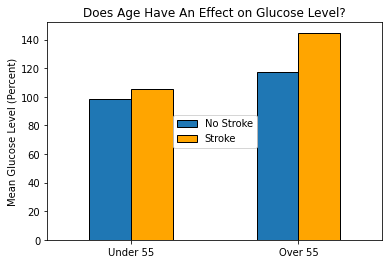

In [24]:
# calculate values for chart
stroke_avg_glucose_level = train.groupby(['is_senior','stroke']).avg_glucose_level.mean().unstack()
stroke_avg_glucose_level.rename(columns={0:'No Stroke', 1:'Stroke'},
                  index = {"False":'Under 55', "True":'Over 55'},
                  inplace=True)

# plot
stroke_avg_glucose_level.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title('Does Age Have An Effect on Glucose Level?')
plt.xlabel('')
plt.ylabel('Mean Glucose Level (Percent)')
plt.legend(loc='center')
plt.show()

- Glucose level is higher for those who have had a stroke in both age groups, but it's a larger difference for those over 55 years old.
- People over 55 years old have a higher glucose level overall than those under 55 years old.

### Visual Determination - Categorical Independent Variables
To check visually if categorical features differ on stroke regardless of age, we will use the feature 'is_senior' to split the data into two age-group samples, Over-55 and Under-55, then inspect bar height differences. The implementation is in the following charts.

Steps:
1. Look for how much bigger/smaller the orange bar is to the blue for Under 55 Years Old.
2. Look at the size difference for Over 55 Years Old.
3. Compare the size difference of Under 55's blue/orange ratio to Over 55's blue/orange ratio.
4. Takeaways come from the comparison in step 3.

### 1. Hyperglycemia (High Glucose)

In [25]:
# Over, Under 55 Years Old: Hyperglycemia and Stroke
stroke_high_glucose = train.groupby(['is_senior','high_glucose']).stroke.mean().unstack()
stroke_high_glucose.rename(columns={"False": "Glucose Under 125",
                                    "True": "Glucose Over 125"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

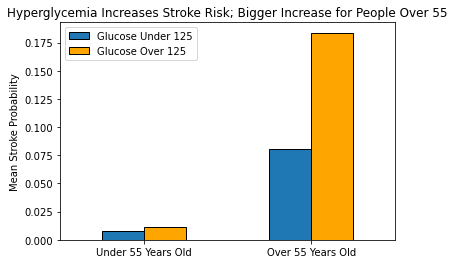

In [26]:
stroke_high_glucose.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Hyperglycemia Increases Stroke Risk; Bigger Increase for People Over 55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Those with hyperglycemia have a higher stroke occurence rate in both age groups.
- The difference is much more significant for those over 55 years old.

### 2. Hypertension

In [27]:
# Over, Under 55 Years Old: Hypertension and Stroke
stroke_has_hypertension = train.groupby(['is_senior','has_hypertension']).stroke.mean().unstack()
stroke_has_hypertension.rename(columns={"False": "No Hypertension",
                                        "True": "Has Hypertension"},
                               index = {"False": "Under 55 Years Old",
                                        "True": "Over 55 Years Old"},
                               inplace=True)

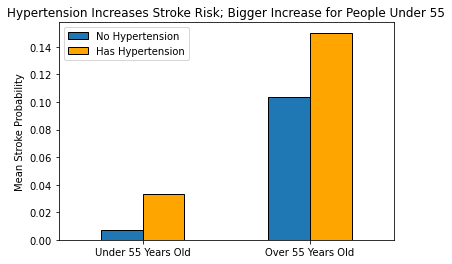

In [28]:
stroke_has_hypertension.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Hypertension Increases Stroke Risk; Bigger Increase for People Under 55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Those who have had a stroke have higher rates of hypertension for both age groups.
- People who have had a stroke under 55 years old have what seems to be a 3x increase of hypertension rate over those without hypertension in the same age group.
- The hypertension ratio between had-stroke and no-stroke for those over 55 years old is much less significant than the ratio for those under 55 years old.

### 3. Heart Disease

In [29]:
# Over, Under 55 Years Old: Heart Disease and Stroke
stroke_has_heart_disease = train.groupby(['is_senior','has_heart_disease']).stroke.mean().unstack()
stroke_has_heart_disease.rename(columns={"False": "No Heart Disease",
                                         "True": "Has Heart Disease"},
                                index = {"False": "Under 55 Years Old",
                                         "True": "Over 55 Years Old"},
                                inplace=True)

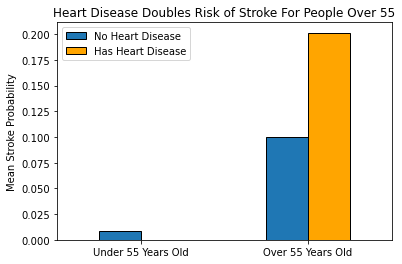

In [30]:
stroke_has_heart_disease.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Heart Disease Doubles Risk of Stroke For People Over 55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Heart disease belongs entirely to those over 55 years old for the ~3,000 observations in our dataset.
- Heart disease seems to double the stroke occurrence rate.

### 4. Ever-Married

In [31]:
# Over, Under 55 Years Old: Ever Married and Stroke
stroke_ever_married = train.groupby(['is_senior','ever_married']).stroke.mean().unstack()
stroke_ever_married.rename(columns={"False": "Never Married",
                                    "True": "Married Before or Now"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

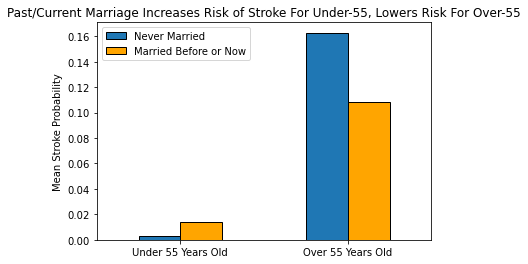

In [32]:
stroke_ever_married.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Past/Current Marriage Increases Risk of Stroke For Under-55, Lowers Risk For Over-55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- The stroke occurrence rate increases for those who married under 55 years old, but decreases for those married over 55 years old.
- The stroke occurrence rate for those who married under 55 years old is nearly triple the rate of those who have not married in the same age group.

### 5. Prior Smoker

In [33]:
# Over, Under 55 Years Old: Prior Smoker and Stroke
stroke_prior_smoker = train.groupby(['is_senior','prior_smoker']).stroke.mean().unstack()
stroke_prior_smoker.rename(columns={"False": "Never Began or Quit Smoking",
                                    "True": "Quit Smoking"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

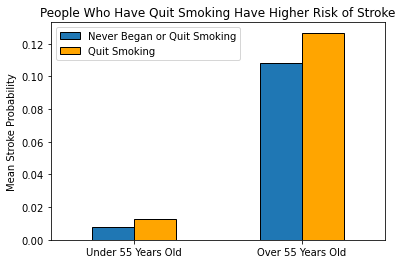

In [34]:
stroke_prior_smoker.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("People Who Have Quit Smoking Have Higher Risk of Stroke")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- People who have specifically quit smoking- excluding those who have never smoked and those who are currently smoking- have a higher stroke occurrence rate in both age groups.
- The ratio for both age groups seems similar, indicating this feature may be dependent on age.

### 6. Self-Employed

In [35]:
# Over, Under 55 Years Old: Self-Employed and Stroke
stroke_self_employed = train.groupby(['is_senior','self_employed']).stroke.mean().unstack()
stroke_self_employed.rename(columns={"False": "Not Self-Employed",
                                    "True": "Self-Employed"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

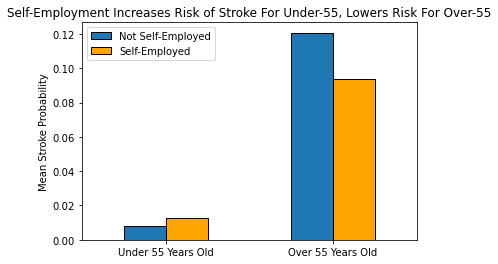

In [36]:
stroke_self_employed.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("Self-Employment Increases Risk of Stroke For Under-55, Lowers Risk For Over-55")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Those who are self-employed and under 55 years old have a higher stroke occurrence rate than the rest of their age group.
- Those who are self-employed and over 55 years old have a lower stroke occurence rate than the rest of their age group.

### 7. Never-Worked

In [37]:
# Over, Under 55 Years Old: Never-Worked and Stroke
stroke_never_worked = train.groupby(['is_senior','never_worked']).stroke.mean().unstack()
stroke_never_worked.rename(columns={"False": "Previously/Currently Employed",
                                    "True": "Never Worked"},
                           index = {"False": "Under 55 Years Old",
                                    "True": "Over 55 Years Old"},
                           inplace=True)

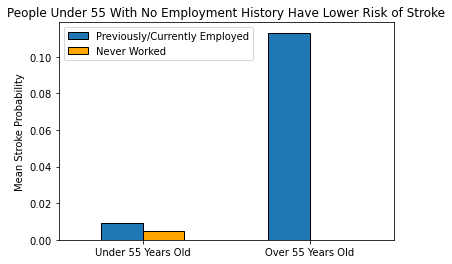

In [38]:
stroke_never_worked.plot.bar(rot=0, color=['#1f77b4','#ffa500'], ec='black')
plt.title("People Under 55 With No Employment History Have Lower Risk of Stroke")
plt.xlabel('')
plt.ylabel('Mean Stroke Probability')
plt.legend()

plt.show()

- Those with no employment history belong entirely to those under 55 years old for our 3,000-observation dataset.
- The stroke occurrence rate of those under 55 years old halves for those who have never worked before.

## Statistical Determination
Using the under-55 and over-55 splits, we will run statistical tests between stroke and a feature on one split, then run it on another split. 
- If the stroke is dependent on the feature in at least one age-group split, then we will keep the feature.
- If the stroke is independent from the feature on both age-group splits, the feature is independent from stroke and will be removed.

### Continuous Features - Comparison of Means, once for each age group

In [39]:
# set alpha
alpha = .05
# create over-55 and under-55 samples
over_55 = train[train.age >= 55]
under_55 = train[train.age < 55]

In [40]:
# create helper function to print results
def double_compare_means(t1, p1, t2, p2, alpha):
    """ 
        Compares p-values for Stroke and a feature for Stroke Prediction dataset, 
        Prints results.
    """
    if p1 < alpha and t1 != 0:
        if p2 < alpha and t2 != 0:
            print(f'Mean value for {col} is different for both age groups.')
        else:
            print(f'Mean value for {col} is different for over-55, not different for under-55.')
    else:
        if p2 < alpha and t2 != 0:
            print(f'Mean value for {col} is not different for over-55, different for under-55.')

        else:
            print(f'Mean value for {col} is not different for both age groups.')

    
    print('')

In [41]:
for col in ['bmi', 'avg_glucose_level']:
    # run test for both age group samples
    t_old, p_old = stats.mannwhitneyu(over_55[over_55.stroke == 1][col],
                                      over_55[over_55.stroke == 0][col],
                                      alternative='two-sided')
    t_young, p_young = stats.mannwhitneyu(under_55[under_55.stroke == 1][col],
                                      under_55[under_55.stroke == 0][col],
                                      alternative='two-sided')
    # print results
    double_compare_means(t_old, p_old, t_young, p_young, alpha)

Mean value for bmi is not different for over-55, different for under-55.

Mean value for avg_glucose_level is different for over-55, not different for under-55.



### Categorical Features - Independence Tests, once for each age group

In [42]:
# set alpha
alpha = .05
# create over-55 and under-55 samples
over_55 = train[train.age >= 55]
under_55 = train[train.age < 55]

In [43]:
# create helper function to print results
def double_independence(p1, p2, alpha):
    """ 
        Compares p-values for Stroke and a feature for Stroke Prediction dataset, 
        Prints results.
    """
    if p1 < alpha:
        if p2 < alpha:
            print(f'{col} and stroke are dependent for both age samples.')
        else:
            print(f'{col} and stroke are dependent for over-55, independent for under-55.')
    else:
        if p2 < alpha:
            print(f'{col} and stroke are independent for over-55, dependent for under-55.')
        else:
            print(f'{col} and stroke are independent for both age samples.')
    
    print('')

In [44]:
# iterate through categorical columns
for col in train.drop(columns='smoking_status').columns[7:]:
    # create crosstabs for stroke and a column for each sample
    over_55_crosstab = pd.crosstab(over_55['stroke'], over_55[col])
    under_55_crosstab = pd.crosstab(under_55['stroke'], under_55[col])
    # run chi2 tests for each sample on stroke and a column
    chi2_over55, p_over55,\
    degf_over55, expected_over55 = stats.chi2_contingency(over_55_crosstab)
    chi2_under55, p_under55,\
    degf_under55, expected_under55 = stats.chi2_contingency(under_55_crosstab)
    # print results
    double_independence(p_over55, p_under55, alpha)

high_glucose and stroke are dependent for over-55, independent for under-55.

has_hypertension and stroke are independent for over-55, dependent for under-55.

has_heart_disease and stroke are dependent for over-55, independent for under-55.

ever_married and stroke are independent for over-55, dependent for under-55.

prior_smoker and stroke are independent for both age samples.

self_employed and stroke are independent for both age samples.

never_worked and stroke are independent for both age samples.



# <center>Exploration Takeaways
## Visual Determination Results
**BMI:**
- BMI is slightly higher for those under 55 years old who have had a stroke, but even for those over 55.
- BMI is similar between age groups.

**Average Glucose Level:**
- Glucose level is higher for those who have had a stroke in both age groups, but it's a larger difference for those over 55 years old.
- People over 55 years old have a higher glucose level overall than those under 55 years old.

**Hyperglycemia:**
- Those with hyperglycemia have a higher stroke occurence rate in both age groups.
- The difference is much more significant for those over 55 years old.

**Hypertension:**
- Those who have had a stroke have higher rates of hypertension for both age groups.
- People who have had a stroke under 55 years old have what seems to be a 3x increase of hypertension rate over those without hypertension in the same age group.
- The hypertension ratio between had-stroke and no-stroke for those over 55 years old is much less significant than the ratio for those under 55 years old.

**Heart Disease:**
- Heart disease belongs entirely to those over 55 years old for the ~3,000 observations in our dataset.
- Heart disease seems to double the stroke occurrence rate.

**Prior/Current Married:**
- The stroke occurrence rate increases for those who married under 55 years old, but decreases for those married over 55 years old.
- The stroke occurrence rate for those who married under 55 years old is nearly triple the rate of those who have not married in the same age group.

**Specifically Quit-Smoking:**
- People who have specifically quit smoking- excluding those who have never smoked and those who are currently smoking- have a higher stroke occurrence rate in both age groups.
- The ratio for both age groups seems similar, indicating this feature may be dependent on age.

**Self-Employed:**
- Those who are self-employed and under 55 years old have a higher stroke occurrence rate than the rest of their age group.
- Those who are self-employed and over 55 years old have a lower stroke occurence rate than the rest of their age group.

**No Employment History:**
- Those with no employment history belong entirely to those under 55 years old for our 3,000-observation dataset.
- The stroke occurrence rate of those under 55 years old halves for those who have never worked before.

## Statistical Testing Results
**Dependent or Different for one age sample (driving stroke):**
1. Mean value for **bmi** is not different for over-55, **different for under-55.**
1. Mean value for **avg_glucose_level** is **different for over-55**, not different for under-55.
1. **high_glucose** and stroke are **dependent for over-55**, independent for under-55.
1. **has_hypertension** and stroke are independent for over-55, **dependent for under-55**.
1. **has_heart_disease** and stroke are **dependent for over-55**, independent for under-55.
1. **ever_married** and stroke are independent for over-55, **dependent for under-55**.

**Independent or Not-Different on both age samples (not driving stroke):**
1. **prior_smoker** and stroke are **independent for both** age samples.
1. **self_employed** and stroke are **independent for both** age samples.
1. **never_worked** and stroke are **independent for both** age samples.

# <center> 3. Model
## a. Modeling Overview
- Encoded features that need it
- Isolated target
- Applied SMOTE + Tomek oversampling to train models on balanced classes
- Built, fit multiple classification models
- Evaluated results of all models on Validate split
- Chose best model to evaluate on Test split
- Evaluated best model on Test split

## b. Building, Fitting, Evaluating Models
### Model Preparation Script - Only Explore-Derived Features - No SMOTE

In [45]:
# use prepare.model_prep__no_smote function here
X_train_no_smote, y_train_no_smote,\
X_validate_no_smote, y_validate_no_smote,\
X_test_no_smote, y_test = prepare.post_analysis_model_prep_no_oversample()

### Model Build+Fit+Predict Script - Only Explore-Derived Features - No SMOTE
- Return non-SMOTEd predictions dataframe, keep separate

In [46]:
# use model.classification_shotgun function here to build predictions dataframe (non-SMOTEd)
no_smote_predictions_train,\
no_smote_predictions_validate = model.classification_shotgun(X_train_no_smote, 
                                                             y_train_no_smote, 
                                                             X_validate_no_smote, 
                                                             y_validate_no_smote)

### Model Preparation Script - Only Explore-Derived Features - with SMOTE

In [47]:
# use SMOTE on the train split here - don't use the model_prep function
X_train, y_train,\
X_validate, y_validate,\
X_test, y_test = prepare.post_analysis_model_prep()

Before SMOTE applied: (3066, 8) (3066,)
After SMOTE applied: (5614, 8) (5614,)


### Model Build+Fit+Predict Script - Only Explore-Derived Features - with SMOTE
- Return SMOTEd predictions dataframe, keep separate

In [48]:
# use model.classification_shotgun function here to build predictions dataframe on SMOTEd data
smote_predictions_train,\
smote_predictions_validate = model.classification_shotgun(X_train, y_train,
                                                          X_validate, y_validate)

### Model Preparation Script - All Features - with SMOTE

In [49]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

In [50]:
df = prepare.prep_data(df)

In [51]:
X_train_all, y_train_all,\
X_validate_all, y_validate_all,\
X_test_all, y_test_all = prepare.model_prep(df)

Before SMOTE applied: (3063, 31) (3063,)
After SMOTE applied: (5832, 31) (5832,)


### Model Build+Fit+Predict Script - All Features - with SMOTE

In [52]:
all_vars_smote_predictions_train,\
all_vars_smote_predictions_validate = model.classification_shotgun(X_train_all, y_train_all,
                                                                   X_validate_all, y_validate_all)

## c. Model Performance on Train, Validate
### Model Evaluation Script - Comparing non-SMOTEd and SMOTEd Models
- Join the non-SMOTEd and SMOTEd dataframes together with column renaming to identify if model incorporated SMOTE or not
- Print evaluation results of joined dataframe as normal
- Show difference between SMOTEd and non-SMOTEd model performance

## Only Explore-Derived Features - without SMOTE - Model Performances

In [53]:
# use model.print_classification_results function here to check results of all models
print('Only Explore-Derived Features - without SMOTE - Model Performances')
model.print_classification_results(no_smote_predictions_train, no_smote_predictions_validate)\
.sort_values(by='OutSample_Recall', ascending=False).head(7)

Only Explore-Derived Features - without SMOTE - Model Performances


,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall
13,nb_vsmooth1e-08,0.8627,0.8483,0.4069,0.40
12,nb_vsmooth1e-09,0.8627,0.8483,0.4069,0.40
15,nb_vsmooth1e-06,0.8633,0.8483,0.4138,0.40
14,nb_vsmooth1e-07,0.8627,0.8483,0.4069,0.40
16,nb_vsmooth1e-05,0.8663,0.8493,0.4207,0.40
17,nb_vsmooth0.0001,0.9142,0.9031,0.3034,0.20
18,nb_vsmooth0.001,0.9224,0.9090,0.2345,0.16


## Only Explore-Derived Features - with SMOTE - Model Performances

In [54]:
# best model (using ever_married): tree_maxdepth1	0.8135	0.6879	0.9177	0.82
# best model (no ever_married): tree_maxdepth1	0.8148	0.6879	0.9202	0.82
print('Only Explore-Derived Features - with SMOTE - Model Performances')
model.print_classification_results(smote_predictions_train, smote_predictions_validate)\
.sort_values(by='OutSample_Recall', ascending=False).head(7)

Only Explore-Derived Features - with SMOTE - Model Performances


,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall
2,tree_maxdepth2,0.8135,0.6879,0.9177,0.82
1,tree_maxdepth1,0.8135,0.6879,0.9177,0.82
19,nb_vsmooth0.01,0.7993,0.7290,0.8603,0.74
18,nb_vsmooth0.001,0.8032,0.7339,0.8636,0.74
6,rf_depth1,0.8215,0.7084,0.9116,0.74
7,rf_depth2,0.8278,0.7260,0.9088,0.74
17,nb_vsmooth0.0001,0.8204,0.7407,0.8817,0.70


## All Features - with SMOTE - Model Performances

In [55]:
print('All Features - with SMOTE - Model Performances')
model.print_classification_results(all_vars_smote_predictions_train,
                                   all_vars_smote_predictions_validate)\
.sort_values(by='OutSample_Recall', ascending=False)

All Features - with SMOTE - Model Performances


,Model,InSample_Accuracy,OutSample_Accuracy,InSample_Recall,OutSample_Recall
13,nb_vsmooth1e-08,0.7236,0.4658,0.9811,0.9661
12,nb_vsmooth1e-09,0.7241,0.4658,0.9822,0.9661
15,nb_vsmooth1e-06,0.7231,0.4697,0.9763,0.9661
14,nb_vsmooth1e-07,0.7222,0.4658,0.9784,0.9661
16,nb_vsmooth1e-05,0.7476,0.5186,0.9719,0.9492
20,nb_vsmooth10,0.7299,0.4834,0.9643,0.9322
17,nb_vsmooth0.0001,0.7567,0.5548,0.9626,0.9322
21,nb_vsmooth100,0.7179,0.4540,0.9654,0.9322
19,nb_vsmooth0.01,0.7841,0.6194,0.9444,0.8983
18,nb_vsmooth0.001,0.7833,0.6125,0.9513,0.8983


### ROC Curve and AUC calculation
- Explain why we're using it here

In [56]:
# create ROC and Precision-Recall visualizations here

## Best Model's Performance on Test

In [57]:
# evaluate best model on Test split here

### Best Model's results on Test
- Explain results here in Markdown

# Modeling Takeaways
- Summarize modeling here

# <center> 4. Risk-Calculation Program
## Risk-Calculation Program Overview

### What it aims to do
- Provide users with a score indicating stroke risk where higher numbers are higher risk
- Uses our best model to calculate the risk score

### Instructions
- Write step-by-step instructions here

## Implementation with Sample Input

In [58]:
# call function here

# <center> Conclusion

## Conclusion
1. Note stats test takeaways
1. Note model performance
1. Explain takeaways
1. Conclude